In [9]:
import random
import string
import urllib.parse
from flask import Flask, redirect, request, jsonify
import base64
import requests 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from dotenv import load_dotenv
import os

In [2]:
load_dotenv()

client_id = os.getenv('CLIENT_ID')
client_secret = os.getenv('CLIENT_SECRET')
redirect_uri = 'http://localhost:3000'
token_generated = 'BQC3Z554BP2NoHA7K_QwJrD5xzhXcc2UL8kbW2YY1u37X2JSDPPJXz8QZobT6TdoVNIUqF8ri3JsePj_glnoZquQucL4bRg9jwEt-U-gsSrFrHplc4sXwieL1wmo18v2NTK2ha5COQip7Jh5BWhm3-mgMVvM2sSqO8cyy9FwF74xHWRqporrXHNPEaCdZVM0WvwnnLDpog'

In [4]:
def get_token(): 
    headers={'Content-Type': 'application/x-www-form-urlencoded'}
    data = {'grant_type':'client_credentials',
        'client_id':client_id,
        'client_secret':client_secret}
    return requests.post("https://accounts.spotify.com/api/token", headers = headers, data = data).json()['access_token']

def get_auth_header(token):
    return {'Authorization' : f'Bearer  {token}'}

In [10]:
app = Flask(__name__)

@app.route('/login')
def login():
    state = ''.join(random.choices(string.ascii_uppercase + string.digits, k=16))
    scope = 'user-follow-read user-read-private user-read-email'

    params = {
        'response_type': 'code',
        'client_id': client_id,
        'scope': scope,
        'redirect_uri': redirect_uri,
        'state': state
    }
    url = 'https://accounts.spotify.com/authorize?' + urllib.parse.urlencode(params)
    return redirect(url)

@app.route('/')
def callback():
    error = request.args.get('error')
    if error:
        return f'Callback error: {error}'
    
    state = request.args.get('state')
    if state != request.args.get('state'):
        return 'State mismatch error'
    
    code = request.args.get('code')
    headers = {
        'Authorization': 'Basic ' + base64.b64encode(f'{client_id}:{client_secret}'.encode()).decode()
    }
    data = {
        'grant_type': 'authorization_code',
        'code': code,
        'redirect_uri': redirect_uri,
    }
    response = requests.post('https://accounts.spotify.com/api/token', headers=headers, data=data)
    response_data = response.json()

    access_token = response_data['access_token']
    refresh_token = response_data['refresh_token']
    expires_in = response_data['expires_in']

    return f'Access Token: {access_token}<br>Refresh Token: {refresh_token}<br>Expires In: {expires_in}'

@app.route('/refresh_token')
def refresh_token():
    refresh_token = request.args.get('refresh_token')
    headers = {
        'Authorization': 'Basic ' + base64.b64encode(f'{client_id}:{client_secret}'.encode()).decode(),
        'Content-Type': 'application/x-www-form-urlencoded'
    }
    data = {
        'grant_type': 'refresh_token',
        'refresh_token': refresh_token,
    }
    response = requests.post('https://accounts.spotify.com/api/token', headers=headers, data=data)
    response_data = response.json()

    access_token = response_data['access_token']
    expires_in = response_data['expires_in']

    return f'Access Token: {access_token}<br>Expires In: {expires_in}'

if __name__ == '__main__':
    app.run(port=3000)

 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:3000
Press CTRL+C to quit
127.0.0.1 - - [01/Apr/2023 13:03:39] "GET /login HTTP/1.1" 302 -
127.0.0.1 - - [01/Apr/2023 13:03:40] "GET /login HTTP/1.1" 302 -
127.0.0.1 - - [01/Apr/2023 13:03:41] "GET /?code=AQASz3v-23NIDvq0vUto_lkLH5zfETqHkXX4vmCHEAuRD-tu6gpOP3_ub1g-bHAt05QLsQr6tPAEcxEVVQsbGtnP63CT9DyWLNHQKMAPVsi_O-2UlRwmz9YHb6iwZg2lv9uNMFqh86jEQ83ZE_gy6IjsJU12wwzN92rlX0LQKlGTTm-ik1oSwpHe1wnvP3MGSip4JCNy-6DWPSZebaPp_iM7ZqfvStbZqMSagNqPzw&state=6MP94JOBAPGOIKCD HTTP/1.1" 200 -
[2023-04-01 13:04:47,126] ERROR in app: Exception on /refresh_token [GET]
Traceback (most recent call last):
  File "c:\Users\augus\AppData\Local\Programs\Python\Python311\Lib\site-packages\flask\app.py", line 2528, in wsgi_app
    response = self.full_dispatch_request()
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\augus\AppData\Local\Programs\Python\Python311\Lib\site-packages\flask\app.py", line 1825, in full_dispatch_request
    rv = self.handle_user_exception(e)
   

In [5]:
url_art = 'https://api.spotify.com/v1/me/following'
params_art = {'type':'artist', 
            'limit': 50}
params_alb = {'include_groups':'album',
                'limit': 50,
                'market':'US'}
header = get_auth_header(token_generated)
res_art = requests.get(url_art, params=params_art, headers=header).json()['artists']['items']
art_names = []
art_ids = []
album_name = []
album_id = []
album_release = []
total_songs = []
genres = []

for i in res_art:
    art_id = i['id']
    url_album = f'https://api.spotify.com/v1/artists/{art_id}/albums'
    res_album = requests.get(url_album, params=params_alb, headers=header).json()['items']
    for j in res_album:
        art_names.append(i['name'])
        art_ids.append(i['id'])
        genres.append(i['genres'])
        album_id.append(j['id'])
        album_name.append(j['name'])
        album_release.append(pd.to_datetime(j['release_date'], infer_datetime_format=True))
        total_songs.append(j['total_tracks'])
        

albums = {
    'art_name':art_names,
    'art_id':art_ids,
    'art_gen': genres,
    'album_name':album_name,
    'album_id':album_id,
    'album_release':album_release,
    'total_tracks':total_songs
}

albums = pd.DataFrame(albums)

In [6]:
url_art = 'https://api.spotify.com/v1/me/following'
params_art = {'type':'artist', 
            'limit': 50}
params_alb = {'include_groups':'single',
                'limit': 50,
                'market':'US'}
header = get_auth_header(token_generated)
res_art = requests.get(url_art, params=params_art, headers=header).json()['artists']['items']
art_names = []
single_name = []
single_release = []

for i in res_art:
    art_id = i['id']
    url_album = f'https://api.spotify.com/v1/artists/{art_id}/albums'
    res_album = requests.get(url_album, params=params_alb, headers=header).json()['items']
    for j in res_album:
        art_names.append(i['name'])
        single_name.append(j['name'])
        single_release.append(pd.to_datetime(j['release_date'], format='%Y-%m-%d'))

singles = {
    'art_name':art_names,
    'single_name':single_name,
    'single_release':single_release,
}

singles = pd.DataFrame(singles)

In [7]:
duration = []
name = []
album_id = []

for i in albums['album_id']:
    url_songs = f'https://api.spotify.com/v1/albums/{i}/tracks'
    params_songs = {'market':'US',
                    'limit':50}
    try:
        res_songs = requests.get(url_songs, headers=header, params=params_songs).json()['items']
        for j in res_songs:
            duration.append(j['duration_ms']/1000)
            name.append(j['name'])
            album_id.append(i)
    except:
        pass

    songs = {
        'name':name,
        'duration':duration,
        'album_id':album_id
    }
    songs = pd.DataFrame(songs)

In [8]:
final = songs.merge(albums, how='left', on='album_id')

In [53]:
final['year_release'] = final['album_release'].apply(lambda x: int(x[:4]))

In [54]:
final['art_gen'] = final['art_gen'].apply(lambda x: ", ".join(x))

In [55]:
def reduce_genres(x):
    genres = ['rock', 'argentine', 'alternative', 'pop', 'funk', 'reggae', 'urbano']
    new_genres = []
    for genre in genres:
        if genre in x:
            new_genres.append(genre)
    return new_genres

In [56]:
final['gen_red'] = final['art_gen'].apply(lambda x: reduce_genres(x))

In [44]:
final_exploded = final.explode('gen_red', ignore_index=True)

<Axes: xlabel='gen_red', ylabel='duration'>

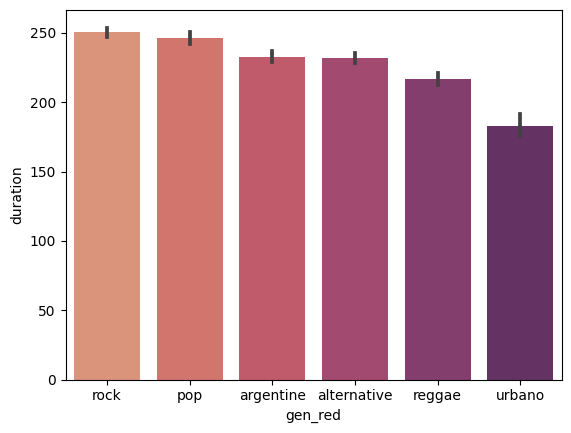

In [45]:
sns.barplot(data=final_exploded, x='gen_red', y='duration', order=['rock', 'pop', 'argentine', 'alternative', 'reggae', 'urbano'], palette='flare')

<Axes: xlabel='year_release', ylabel='duration'>

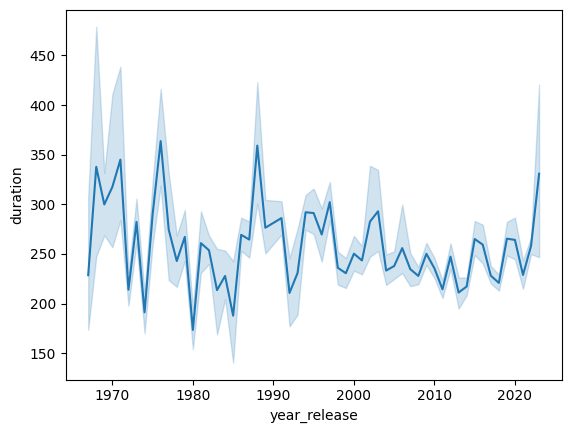

In [46]:
sns.lineplot(data=final, x='year_release', y='duration')

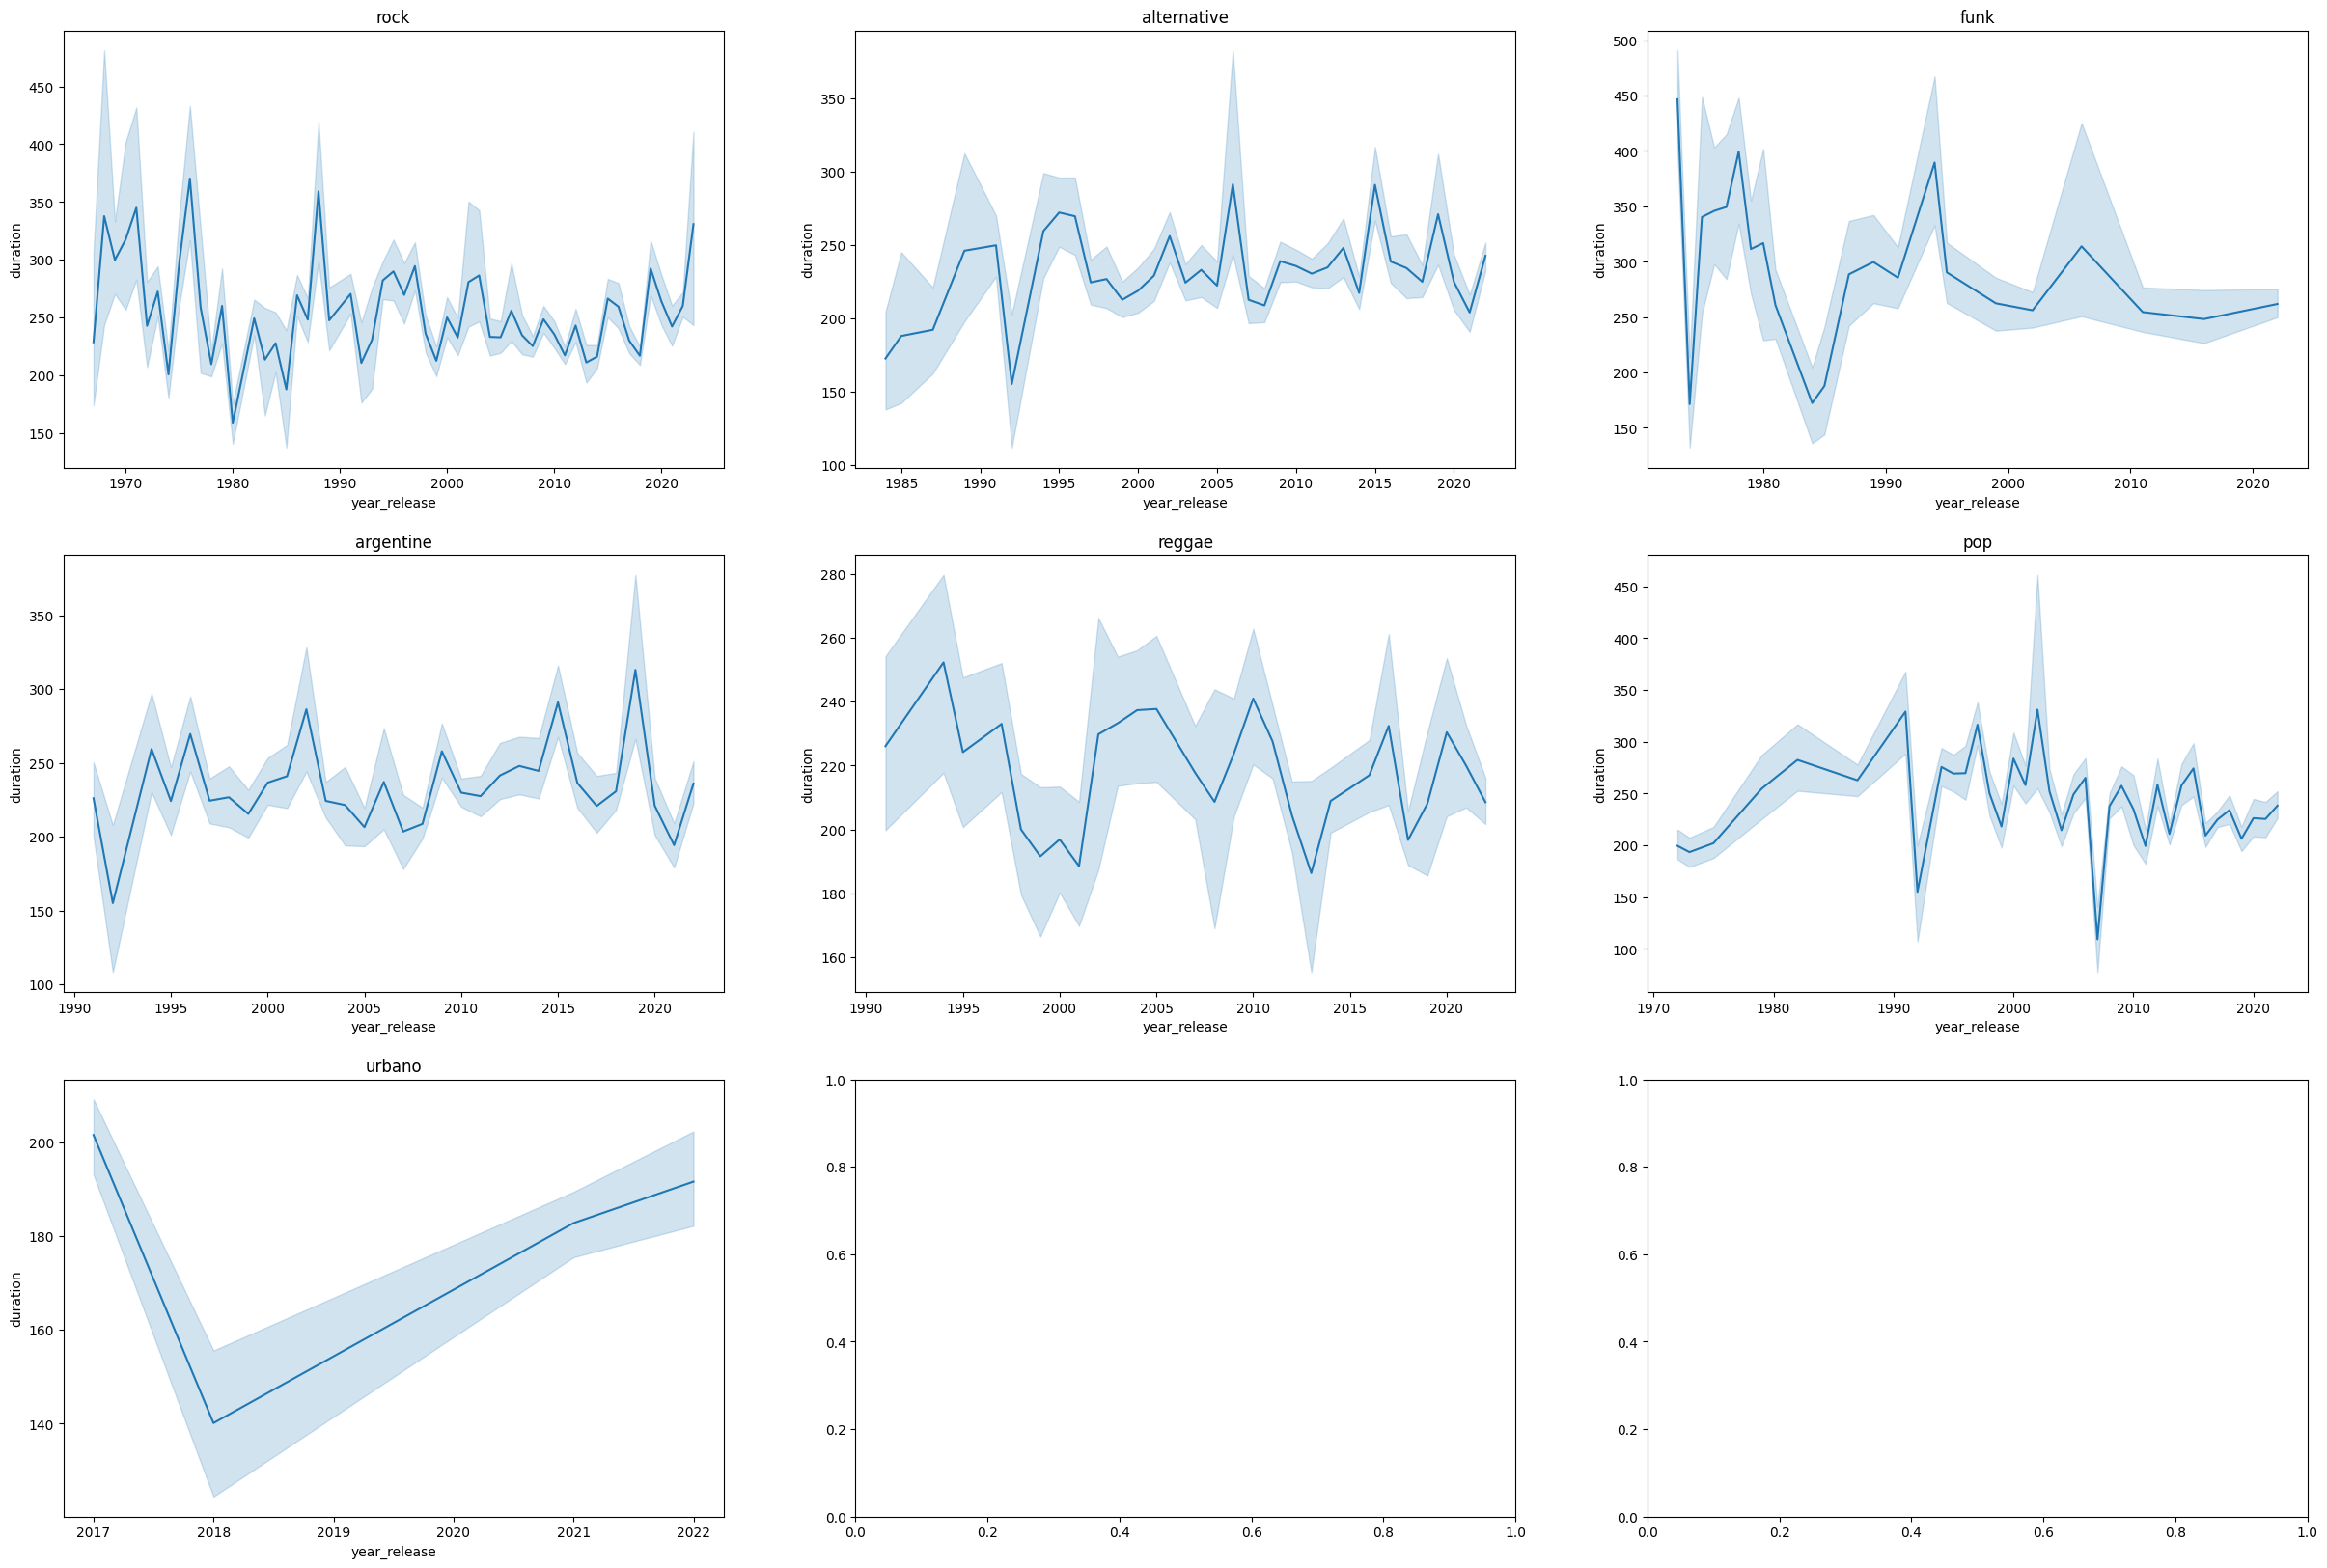

In [50]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(30,20))
j=0
k=0
for i in final_exploded['gen_red'].unique():
    sub = sns.lineplot(data=final_exploded[final_exploded['gen_red'] == i], x='year_release', ax=axs[k][j], y='duration')
    sub.set(title=i)
    j+=1
    if j == 3:
        k+=1
        j=0


In [81]:
singles = singles.rename(columns={'single_name':'single/album name', 'single_release':'single/album release'})
singles = singles.sort_values(by='single/album release',ascending=False)

In [82]:
albums_new = albums[['art_name', 'album_name', 'album_release']]
albums_new = albums_new.rename(columns={'album_name':'single/album name', 'album_release':'single/album release'}).sort_values(by='single/album release', ascending=False)

In [83]:
new_releases = pd.concat([singles, albums_new])


In [85]:
new_releases.reset_index(drop=True).head()

,art_name,single/album name,single/album release
0,Bizarrap,"Arcángel: Bzrp Music Sessions, Vol. 54",2023-03-22
1,Picture This,Song To Myself,2023-03-17
2,Pink Floyd,Time (edit - 2023 Master),2023-03-16
3,Dirty Heads,Rescue Me,2023-02-24
4,Crash Adams,California Girl,2023-02-17
